In [292]:
!pip install --upgrade geopandas

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [293]:
!pip install --upgrade ptitprince

Requirement already up-to-date: ptitprince in /usr/local/lib/python3.6/dist-packages (0.2.3)


In [294]:
!pip install --upgrade joypy

Requirement already up-to-date: joypy in /usr/local/lib/python3.6/dist-packages (0.2.2)


In [0]:
import pandas as pd
import numpy as np
import ptitprince as pt
import sys
import geopandas
import seaborn as sns
import joypy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#from plotly import graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import ListedColormap
from matplotlib import cm
%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1Pk5MK9Hs_kMUT9NotGnOKE0NPra-39YU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train.csv')

In [0]:
id='1x2hD3cLZOxINbbMQNexkuPIgHYdJYKyO'
downloaded2 = drive.CreateFile({'id': id})
downloaded2.GetContentFile('usa_states.csv')

In [299]:
train = pd.read_csv('train.csv', encoding='latin-1')
train['longitud'] = train['text'].apply(len)
train.head(500)

,id,keyword,location,text,target,longitud
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...,...,...
495,717,attacked,London,Christian Attacked by Muslims at the Temple Mo...,1,122
496,719,attacked,london / st catharines ?,#TBT Remember that time Patrick Kane attacked ...,0,67
497,720,attacked,NaN,im feeling attacked http://t.co/91jvYCxXVi,0,42
498,721,attacked,Peshawar,IK Only Troll His Pol Rivals Never Literally A...,0,130


In [300]:
train.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
longitud    7613
dtype: int64

In [301]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   longitud  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


#Datos relevantes

Porcentaje de tweets falsos vs verídicos

In [302]:
verdaderos = train['target'].sum()
falsos = train['target'].count() - train['target'].sum()
verdaderos

3271

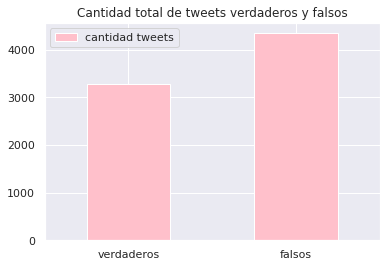

In [303]:
true_vs_false = pd.DataFrame({'cantidad tweets': [train['target'].sum(), train['target'].count() - train['target'].sum()], 'porcentaje':[train['target']]}, index=['verdaderos', 'falsos'])
true_vs_false.plot.bar(rot=0, title='Cantidad total de tweets verdaderos y falsos', color='pink')

In [304]:
tw_mas_largo = train['longitud'].max()
tw_mas_largo

163

In [305]:
train.max()

id                                                      10873
text        Ã¥ÃMGN-AFRICAÃ¥Â¨ pin:263789F4 Ã¥Ã Correctio...
target                                                      1
longitud                                                  163
dtype: object

In [306]:
train.min()

id                                                          1
text        ! Residents Return To Destroyed Homes As Washi...
target                                                      0
longitud                                                    7
dtype: object

#Filtrado de datos por localidad

Filtrado manual del DataFrame las localidades que no existen o son vacias/NaN.

In [307]:
df_filter_location = train.copy()
del df_filter_location['id']
df_filter_location.dropna(subset=['location'], inplace = True)
df_filter_location = df_filter_location[df_filter_location.location != '  ']
df_filter_location.count()

keyword     5079
location    5079
text        5079
target      5079
longitud    5079
dtype: int64

In [308]:
def eliminar_localidades_no_existentes(location):
  if (location.find('www.') != -1 or location.find('WWW.') != -1):
    return np.nan
  if (location.find(',') != -1 or location.find('.') != -1):
    loc = location.replace(',', '')
    loc = location.replace('.', '')
    if loc.isalpha() and (len(loc) < 100): #valuación del estado del csv a analizar
     return location.upper()
  if location.isalpha() and (len(location) < 100):
    return location.upper()
  return np.nan

df_filter_location['location'] = df_filter_location['location'].transform(eliminar_localidades_no_existentes)
df_filter_location.dropna(subset=['location'], inplace = True)
df_filter_location.count()

keyword     1357
location    1357
text        1357
target      1357
longitud    1357
dtype: int64

In [309]:
df_filter_location['country'] = df_filter_location['location']
df_filter_location.head()

,keyword,location,text,target,longitud,country
31,ablaze,BIRMINGHAM,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,BIRMINGHAM
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,AFRICA
36,ablaze,PRETORIA,@PhDSquares #mufc they've built so much hype a...,0,122,PRETORIA
49,ablaze,ENGLAND.,First night with retainers in. It's quite weir...,0,138,ENGLAND.
51,ablaze,INDIA,Man wife get six years jail for setting ablaze...,1,75,INDIA


In [310]:
df_filter_location['country'] = df_filter_location['location'].replace("U.S.A", "USA")
df_filter_location['country'] = df_filter_location['location'].replace("UNITED STATES", "USA")
df_filter_location['country'] = df_filter_location['location'].replace("U.S", "USA")
df_filter_location['country'] = df_filter_location['location'].replace("US", "USA")
df_filter_location.country.value_counts()

USA          114
LONDON        49
CANADA        33
WORLDWIDE     31
NIGERIA       31
            ... 
SURABAYA       1
ROYTON         1
CARIBBEAN      1
WOOSLEY        1
PHILA.         1
Name: country, Length: 496, dtype: int64

#Filtrado de tweets por keyword


Filtro del DataFrame los tweets cuya keyword sea NaN

In [311]:
df_filter_keyword_sin_nan = train.copy()
df_filter_keyword_sin_nan.dropna(subset=['keyword'], inplace = True)
df_filter_keyword_sin_nan.head(400)

,id,keyword,location,text,target,longitud
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76
...,...,...,...,...,...,...
426,617,arsonist,ss,@58hif my trick is to think about nasty things,0,46
427,619,arsonist,"Winston Salem, North Carolina",#Spotlight Take Me To Paradise by Arsonist MC ...,0,118
428,621,arsonist,ss,who makes these? http://t.co/28t3NWHdKy,0,39
429,622,arsonist,NaN,on town of salem i just melted ice cube bc im ...,0,61


In [312]:
df_keyword_con_nan = train.copy()
df_keyword_con_nan['keyword'] = df_keyword_con_nan[df_keyword_con_nan['keyword'] == np.nan]
df_keyword_con_nan.head()

,id,keyword,location,text,target,longitud
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


#ANALISIS EXPLORATORIO

¿En qué localidad hay más tweets? USA

In [313]:
cantidad_tweets_location = df_filter_location.loc[:,['text', 'location']].groupby('location').agg({'text': 'count'})
cantidad_de_tweets_por_localidad_ordenado = cantidad_tweets_location.sort_values(by='text', ascending=False).head(10)
cantidad_de_tweets_por_localidad_ordenado

,text
location,
USA,104
LONDON,49
CANADA,33
NIGERIA,31
WORLDWIDE,31
UK,30
INDIA,28
MUMBAI,24
KENYA,21


Grafico de barras -  Cantidad de tweets por localidad

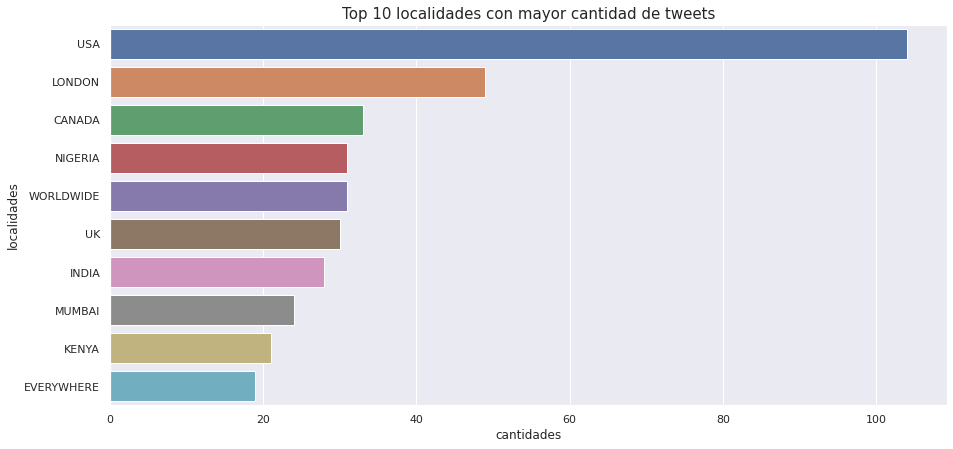

In [314]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=cantidad_de_tweets_por_localidad_ordenado['text'], \
                y=cantidad_de_tweets_por_localidad_ordenado.index, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad de tweets", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top 10 localidades.png")

Vericidad de los tweets por localidad

In [315]:
cantidad_tweets_veridicos_location = df_filter_location.loc[:, ['location', 'target']].groupby('location').agg({'target': ['count','sum']})
cantidad_tweets_veridicos_location.columns = ['Cantidad total tweets', 'Cantidad verídicos']
df = cantidad_tweets_veridicos_location.sort_values(by='Cantidad verídicos', ascending=False).head(10)
df

,Cantidad total tweets,Cantidad verídicos
location,,
USA,104,67
NIGERIA,31,24
INDIA,28,22
MUMBAI,24,19
WORLDWIDE,31,19
LONDON,49,17
CANADA,33,17
UK,30,17
EARTH,12,9


Top 10 localidades - localidades con más tweets

In [316]:
df_veracidad_location = cantidad_tweets_veridicos_location.sort_values(by='Cantidad total tweets', ascending=False).head(10)
df_veracidad_location

,Cantidad total tweets,Cantidad verídicos
location,,
USA,104,67
LONDON,49,17
CANADA,33,17
NIGERIA,31,24
WORLDWIDE,31,19
UK,30,17
INDIA,28,22
MUMBAI,24,19
KENYA,21,5


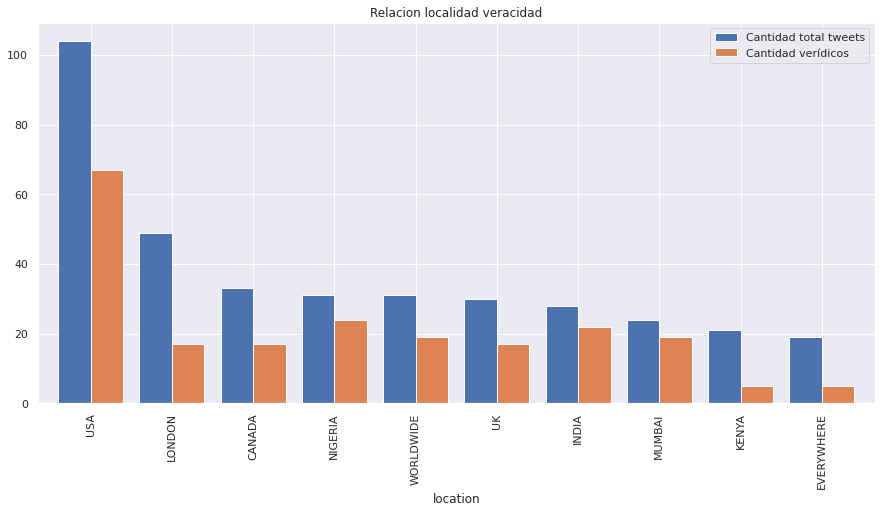

In [317]:
df_veracidad_location.plot(kind = 'bar',
             width=0.8,
             figsize=(15,7), title='Relacion localidad veracidad')

Distribucion de los largos de los tweets en la localidad con mas tweets (USA)


In [318]:
localidad_con_mas_tweets = df_filter_location.groupby('location').get_group('USA')
localidad_con_mas_tweets

,keyword,location,text,target,longitud,country
55,ablaze,USA,#Kurds trampling on Turkmen flag later set it ...,1,135,USA
203,ambulance,USA,Twelve feared killed in Pakistani air ambulanc...,1,98,USA
223,annihilated,USA,One thing for sure-God has promised Israel wil...,0,125,USA
316,armageddon,USA,YOUR PHONE IS SPYING ON YOU! Hidden Back Door ...,0,125,USA
382,arson,USA,Thousands attend a rally organized by Peace No...,1,123,USA
...,...,...,...,...,...,...
7341,wildfire,USA,The Latest: Washington #Wildfire misses town; ...,1,100,USA
7356,wildfire,USA,The Latest: #Wildfire destroys more homes but ...,1,100,USA
7413,wounded,USA,One man fatally shot another wounded on Vermon...,1,88,USA
7420,wounded,USA,Police Officer Wounded Suspect Dead After Exch...,1,99,USA


In [0]:
localidad_con_mas_tweets_veridicos = localidad_con_mas_tweets[localidad_con_mas_tweets['target'] == 1]
localidad_con_mas_tweets_falsos = localidad_con_mas_tweets[localidad_con_mas_tweets['target'] != 1]

Text(0.5, 1.0, 'Distribucion longitudes de tweets - USA')

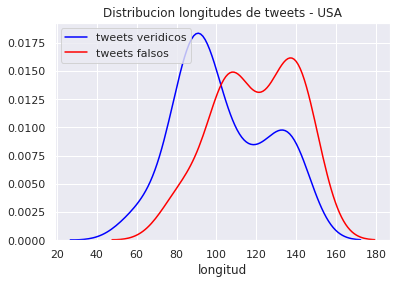

In [320]:
x= localidad_con_mas_tweets_veridicos['longitud']
y= localidad_con_mas_tweets_falsos['longitud']
sns.distplot(x, hist=False,color="blue", label= 'tweets veridicos')
sns.distplot(y, hist=False,color="red", label= 'tweets falsos').set_title('Distribucion longitudes de tweets - USA')

Distribución de la cantidad de tweets por estado en USA

In [321]:
usa = pd.read_csv('usa_states.csv', encoding='latin-1')
usa

,state,short_name,cod
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA
5,Colorado,Colo.,CO
6,Connecticut,Conn.,CT
7,Delaware,Del.,DE
8,District of Columbia,D.C.,DC
9,Florida,Fla.,FL


In [322]:
train_copy = train.copy()
train_copy.columns = ['id', 'keyword', 'state', 'text', 'target', 'longitud']
usa_states_train_1 = pd.merge(usa, train_copy, how='inner', on='state')
usa_states_train_1.count()

state         204
short_name    204
cod           204
id            204
keyword       204
text          204
target        204
longitud      204
dtype: int64

In [323]:
train_copy.columns = ['id', 'keyword', 'short_name', 'text', 'target', 'longitud']
usa_states_train_2 = pd.merge(usa, train_copy, how='inner', on='short_name')
usa_states_train_2.count()

state         8
short_name    8
cod           8
id            8
keyword       8
text          8
target        8
longitud      8
dtype: int64

In [324]:
train_copy.columns = ['id', 'keyword', 'cod', 'text', 'target', 'longitud']
usa_states_train_3 = pd.merge(usa, train_copy, how='inner', on='cod')
usa_states_train_3.count()

state         32
short_name    32
cod           32
id            32
keyword       32
text          32
target        32
longitud      32
dtype: int64

In [325]:
frames = [usa_states_train_1, usa_states_train_2, usa_states_train_3]
usa_states = pd.concat(frames)
usa_states

,state,short_name,cod,id,keyword,text,target,longitud
0,Alabama,Ala.,AL,1835,burned,Alton brown just did a livestream and he burne...,0,136
1,Alabama,Ala.,AL,8288,rioting,http://t.co/jMzcaqyDfa Cindy Noonan@CindyNoon...,0,117
2,Alaska,Alaska,AK,4628,emergency%20services,#Healthcare #Job in #Kodiak AK: Emergency Serv...,0,141
3,Alaska,Alaska,AK,7108,military,Mike Magner Discusses A Trust Betrayed: http:/...,0,108
4,Arizona,Ariz.,AZ,3619,desolation,Did Josephus get it wrong about Antiochus Epip...,0,120
...,...,...,...,...,...,...,...,...
27,Pennsylvania,Pa.,PA,956,blaze,pic of me and blaze in a fort when we were kid...,0,125
28,Pennsylvania,Pa.,PA,7799,quarantine,Reddit Will Now Quarantine Offensive Content h...,0,67
29,Tennessee,Tenn.,TN,10826,wrecked,On the bright side I wrecked http://t.co/uEa0t...,0,51
30,Texas,Tex.,TX,5249,fatality,Fatality scary af. Probably not the best falco...,0,64


In [326]:
usa_states_grafico = usa_states.groupby('state').agg({'target':'count'})
usa_states_grafico

,target
state,
Alabama,2
Alaska,4
Arizona,4
Arkansas,1
California,20
Colorado,6
Connecticut,2
District of Columbia,2
Florida,14


In [327]:
fig = go.Figure(go.Treemap(
    labels = usa_states_grafico.index.to_list(),
    parents = ['USA']*(len(usa_states_grafico.index.to_list())),
    values= usa_states_grafico.target.to_list(),
    textinfo='label+value'
  ))

fig.update_layout(treemapcolorway = ["lightgreen"],
                 title= 
                  {
                    'text': "Distribución de cantidad de tweets en los diferentes estados de USA",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'
                  }
                 )

fig.show()

Comparación porcentajes de verídicos con respecto a falsos en cada localidad

In [0]:
def contar_falsos(x):
  return x.count() - x.sum()

def porcentaje_veridicos(x):
  return (x.sum()/x.count())*100

In [329]:
comparacion_tweets_veridicos_location = df_filter_location.groupby('location').agg({'target': ['sum', contar_falsos]})
#comparacion_tweets_veridicos_location.sort_values(by='target', ascending=False).head()
comparacion_tweets_veridicos_location.columns = ['Tweets verdaderos', 'Tweets falsos']
comparacion_tweets_veridicos_location = comparacion_tweets_veridicos_location.sort_values(by='Tweets verdaderos', ascending=False)
comparacion_tweets_veridicos_location

,Tweets verdaderos,Tweets falsos
location,,
USA,67,37
NIGERIA,24,7
INDIA,22,6
MUMBAI,19,5
WORLDWIDE,19,12
...,...,...
DELHI,0,1
NIRVANA,0,1
NORTH,0,1


Relacion entre la veracidad del tweet y la keyword.

In [330]:
cantidad_veridicos_sin_nan = df_filter_keyword_sin_nan['target'].sum()
cantidad_falsos_sin_nan = df_filter_keyword_sin_nan['target'].count() - cantidad_veridicos_sin_nan
promedio_de_veridicos_sin_nan = (cantidad_veridicos_sin_nan / df_filter_keyword_sin_nan['keyword'].count() * 100) 
promedio_de_veridicos_sin_nan

42.75688559322034

In [331]:
hola = df_filter_keyword_sin_nan.groupby('keyword').agg({'text':'count'})
hola.count()

text    221
dtype: int64

In [332]:
cantidad_veridicos_con_nan = df_keyword_con_nan['target'].sum()
cantidad_falsos_con_nan = df_keyword_con_nan['target'].count() - cantidad_veridicos_con_nan
promedio_de_veridicos_con_nan = (cantidad_veridicos_con_nan / df_keyword_con_nan['target'].count() * 100)
promedio_de_veridicos_con_nan

42.96597924602653

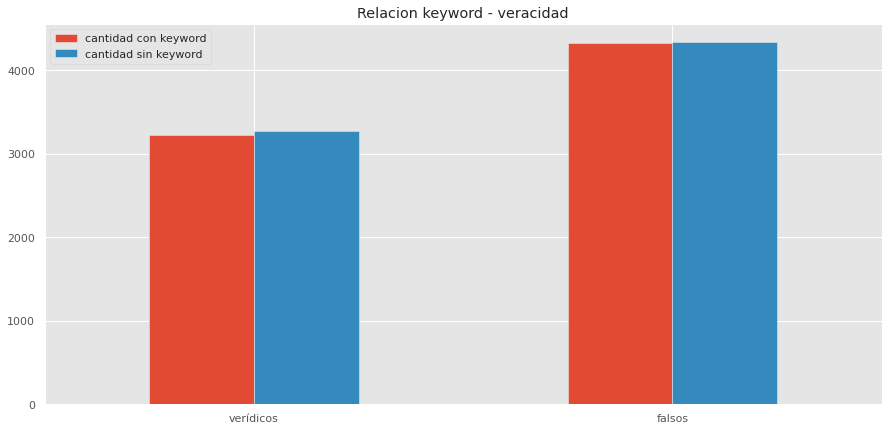

In [333]:
plt.style.use('ggplot')
df_grafico = pd.DataFrame({'cantidad con keyword': [cantidad_veridicos_sin_nan, cantidad_falsos_sin_nan], 'cantidad sin keyword': [cantidad_veridicos_con_nan, cantidad_falsos_con_nan]}, index=['verídicos', 'falsos'])
df_grafico.plot.bar(rot=0, figsize=(15,7), title='Relacion keyword - veracidad')

Cantidad de tweets por keyword. Relación con la veracidad

In [334]:
groupedby_keyword = df_filter_keyword_sin_nan.loc[:, ['keyword', 'target']].groupby('keyword').agg({'target': ['count','sum']})
groupedby_keyword.columns = ['Cantidad total tweets', 'Cantidad verídicos']
groupedby_keyword.head()

,Cantidad total tweets,Cantidad verídicos
keyword,,
ablaze,36,13
accident,35,24
aftershock,34,0
airplane%20accident,35,30
ambulance,38,20


In [0]:
df = groupedby_keyword.sort_values(by='Cantidad total tweets', ascending=False).head(10)
df.index = df.index.str.replace('%20', ' ')

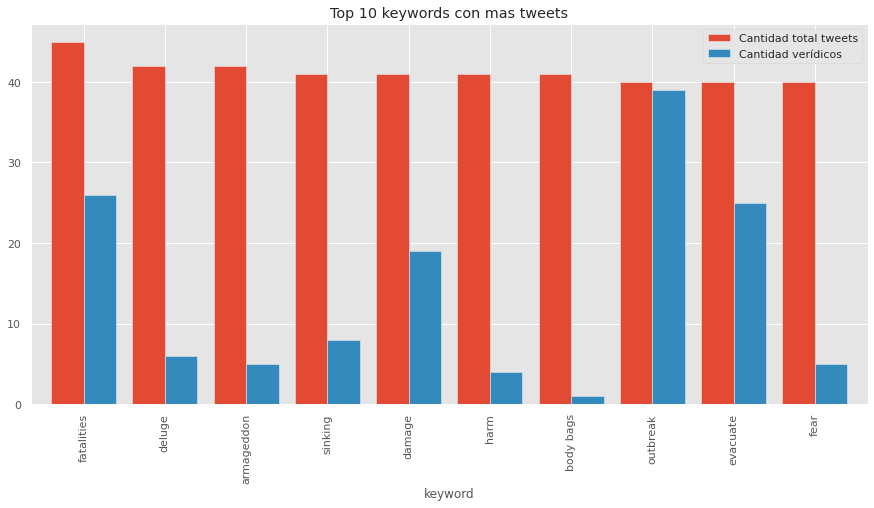

In [336]:
bar = df.plot(kind = 'bar',width=0.8,figsize=(15,7), title="Top 10 keywords con mas tweets")

Búsqueda de localidades de los tweets en las keyword mas utilizadas.


In [0]:
df_all_filters = df_filter_location.copy()
df_all_filters.dropna(subset=['keyword'], inplace = True)
df_all_filters['keyword'] = df_all_filters['keyword'].str.replace('%20', ' ')

In [338]:
tabla = df_all_filters[['keyword', 'location', 'target']].pivot_table(index='keyword',columns='location',values='target', aggfunc='count')
tabla

location,ABERDEENSHIRE,ABUJA,ADELAIDE,AEP,AFGHANISTAN,AFRICA,ALABAMA,ALASKA,ALBUQUERQUE,AMARILLO,AMERICA,AMSTERDAM,ANAHEIM,ANONYMOUS,ANTARCTICA,ANYWHERE,ARBAILO,ARGENTINA,ARIZONA,ARKANSAS,ASGARD,ASIA,ATLANTA,ATMOSPHERE,ATTOCK,ATX,AUCKLAND,AUS,AUSTIN,AUSTRALIA,AVA,AVON,AYR,AZ,AZEROTH,BACON,BAHRAIN,BAJAUR,BALTIMORE,BALVANERA,...,VENTURA,VIEJO,VIETNAM,VILNIUS,VINEYARD,VIRGINIA,WADDESDON,WAKANDA,WALES,WANDERLUST,WARRI,WARSAW,WARSZAWA,WASHINGTON,WATERFRONT,WATFORD,WELLINGTON,WELT,WEST,WESTCHESTER,WESTERLAND,WESTWESTWESTWESTWESTWESTWEST,WEYBURN,WILTSHIRE,WINNIPEG,WISCO,WISCONSIN,WNY,WOLVERHAMPTON,WOOSLEY,WORDLDWIDE,WORLD,WORLDWIDE,WORLDWIDE.,WORLDWIDEWEB,WREX,YELLOWKNIFE,YLISSE,YOOOOOOO,ZIMBABWE
keyword,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ablaze,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aftershock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airplane accident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ambulance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wounded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wreck,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
tabla.to_csv('tabla.csv')

In [340]:
cant_k_loc = df_all_filters.groupby('location').agg({'keyword':'count'})
cant_k_loc.sort_values(by='keyword', ascending=False)

,keyword
location,
USA,104
LONDON,49
CANADA,33
NIGERIA,31
WORLDWIDE,31
...,...
HOUSTN,1
HOMRA.,1
HOLLYWOOD,1


En qué localidad hay más tweets que el promedio?

In [341]:
cantidad_t_localidad = df_filter_location.groupby('location').agg({'target':'count'})
promedio = cantidad_t_localidad['target'].sum()/cantidad_t_localidad.count()
localidades_con_mas_tweets_que_promedio = cantidad_t_localidad[cantidad_t_localidad['target']> int(promedio)]
localidades_con_mas_tweets_que_promedio.head()

,target
location,
AFRICA,5
AMERICA,3
ANONYMOUS,3
ARGENTINA,4
ARIZONA,4


Para gráfico longitud vs frecuencia

In [342]:
tweets_por_longitud = df_all_filters.groupby('longitud').agg({'target':'count'})
new_index = ['id']
tweets_por_longitud['id'] = 0
tweets_por_longitud = tweets_por_longitud.unstack()
tweets_por_longitud.columns = ['longitud', 'cantidad']
tweets_por_longitud
df_all_filters

,keyword,location,text,target,longitud,country
31,ablaze,BIRMINGHAM,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,BIRMINGHAM
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,AFRICA
36,ablaze,PRETORIA,@PhDSquares #mufc they've built so much hype a...,0,122,PRETORIA
49,ablaze,ENGLAND.,First night with retainers in. It's quite weir...,0,138,ENGLAND.
51,ablaze,INDIA,Man wife get six years jail for setting ablaze...,1,75,INDIA
...,...,...,...,...,...,...
7548,wrecked,PENNSYLVANIA,Four hundred wrecked cars (costing $100 apiece...,0,120,PENNSYLVANIA
7570,wrecked,CALIFORNIA,Cramer: Iger's 3 words that wrecked Disney's s...,0,88,CALIFORNIA
7574,wrecked,GLOBAL,Cramer: 3 words that wrecked DIS stock - http:...,0,63,GLOBAL
7575,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,51,TN


Relacion keyword - localidad

In [343]:
tabla = df_all_filters[['keyword', 'location', 'target']].pivot_table(index='keyword',columns='location',values='target', aggfunc='count')
maxValuesObj = tabla.idxmax(axis=1)
maxCantidades = tabla.max(axis=1)
d = {'localidades maximas': maxValuesObj, 'cantidad por localidad': maxCantidades}
maximas_localidades_en_keyword = pd.DataFrame(data=d)
maximas_localidades_en_keyword = maximas_localidades_en_keyword.reset_index().rename(columns={df.index.name: 'keyword'})
maximas_localidades_en_keyword

,keyword,localidades maximas,cantidad por localidad
0,ablaze,BIRMINGHAM,2.0
1,accident,UK,2.0
2,aftershock,SWITZERLAND,4.0
3,airplane accident,BANGALORE,1.0
4,ambulance,AMSTERDAM,1.0
...,...,...,...
214,wounded,USA,3.0
215,wounds,CHARLOTTE,1.0
216,wreck,ARGENTINA,1.0
217,wreckage,MUMBAI,10.0


Distribución de la longitud de acuerdo a la veracidad

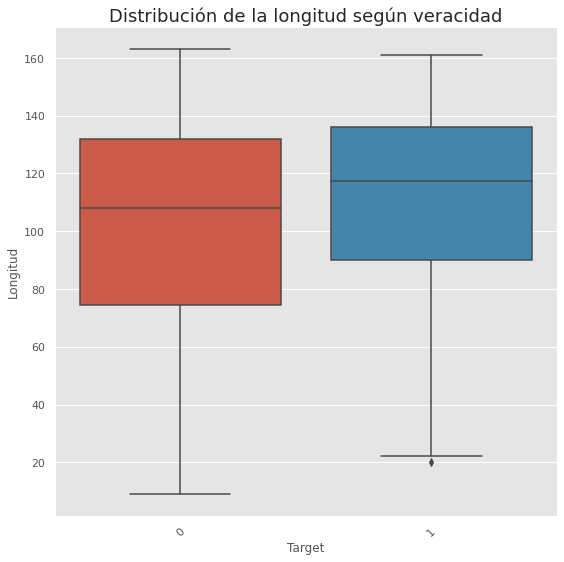

In [344]:
fig, ax = plt.subplots(figsize = (9, 9))
g = sns.boxplot(x='target', y='longitud', data=df_all_filters, ax= ax)
g.set_title('Distribución de la longitud según veracidad', fontsize=18);
g.set_ylabel('Longitud');
g.set_xlabel('Target');
g.set_xticklabels(g.get_xticklabels(), rotation=45);

Veracidad por longitud de tweets

In [345]:
def target_longitud(x):
  if x.sum() > x.count() - x.sum():
    return 1
  return 0

grouped_target_long = df_all_filters.groupby(['longitud']).agg({'target': ['count', target_longitud]})
grouped_target_long.columns = ['Cantidad de tweets', 'Target']
grouped_target_long['Longitud del tweet'] = grouped_target_long.index
grouped_target_long

,Cantidad de tweets,Target,Longitud del tweet
longitud,,,
9,1,0,9
11,1,0,11
12,2,0,12
13,1,0,13
15,1,0,15
...,...,...,...
151,1,0,151
152,1,0,152
153,1,0,153


Text(0.52, 1, 'Distribución cantidad de tweets - longitud')

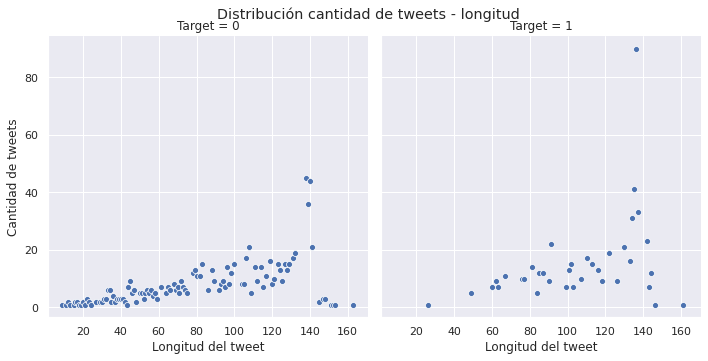

In [346]:
sns.set()
g = sns.relplot(x='Longitud del tweet', y='Cantidad de tweets', col='Target', data=grouped_target_long)
g.fig.suptitle("Distribución cantidad de tweets - longitud", x=0.52, y=1)

Cantidad de tweets verdaderos y falsos por longitud

In [347]:
grouped_cant_long = df_all_filters.groupby(['longitud']).agg({'target': ['sum', contar_falsos, 'count']})
grouped_cant_long.columns = ['V', 'F', 'total']
grouped_cant_long['Longitud'] = grouped_cant_long.index
grouped_cant_long

,V,F,total,Longitud
longitud,,,,
9,0,1,1,9
11,0,1,1,11
12,0,2,2,12
13,0,1,1,13
15,0,1,1,15
...,...,...,...,...
151,0,1,1,151
152,0,1,1,152
153,0,1,1,153


In [348]:
grouped_cant_long['total'].max()

90

Text(0, 0.5, 'Cantidad de tweets')

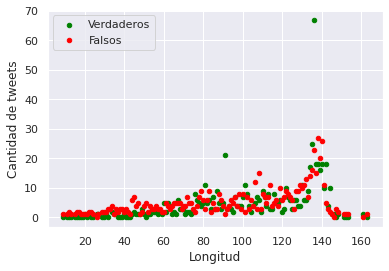

In [349]:
ax = grouped_cant_long.plot(kind='scatter', x='Longitud', y='V',color='Green', label='Verdaderos')

graf = grouped_cant_long.plot(kind='scatter', x='Longitud', y='F',
         color='Red', label='Falsos', ax=ax)
graf.set_ylabel('Cantidad de tweets')

Distribucion del target en funcion de la longitud

Text(0.5, 1.0, 'Distribucion del target en funcion de la longitud')

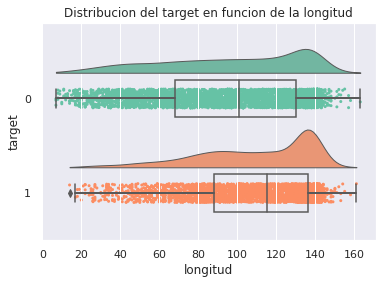

In [350]:
ax = pt.RainCloud(x = 'target', y = 'longitud',
                 data = train,
                 width_viol = .8,
                 width_box = .4,
                 figsize = (50, 50),
                 orient = 'h')
ax.set_title('Distribucion del target en funcion de la longitud')

#MAPA

In [351]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.count()

pop_est       177
continent     177
name          177
iso_a3        177
gdp_md_est    177
geometry      177
dtype: int64

In [352]:
train.columns = ['id', 'keyword', 'continent', 'text', 'target', 'longitud']
world_train_1 = pd.merge(world, train, how='inner', on='continent')
world_train_1.count()

pop_est       391
continent     391
name          391
iso_a3        391
gdp_md_est    391
geometry      391
id            391
keyword       391
text          391
target        391
longitud      391
dtype: int64

In [353]:
train.columns = ['id', 'keyword', 'name', 'text', 'target', 'longitud']
world_train_2 = pd.merge(world, train, how='inner', on='name')
world_train_2.count()

pop_est       269
continent     269
name          269
iso_a3        269
gdp_md_est    269
geometry      269
id            269
keyword       269
text          269
target        269
longitud      269
dtype: int64

In [354]:
train.columns = ['id', 'keyword', 'iso_a3', 'text', 'target', 'longitud']
world_train_3 = pd.merge(world, train, how='inner', on='iso_a3')
world_train_3.count()

pop_est       106
continent     106
name          106
iso_a3        106
gdp_md_est    106
geometry      106
id            106
keyword       106
text          106
target        106
longitud      106
dtype: int64

In [355]:
frames = [world_train_1, world_train_2, world_train_3]
world_train_final = pd.concat(frames)
world_train_final.count()

pop_est       766
continent     766
name          766
iso_a3        766
gdp_md_est    766
geometry      766
id            766
keyword       766
text          766
target        766
longitud      766
dtype: int64

In [356]:
world_train_final.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,id,keyword,text,target,longitud
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136
2,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",10748,wreckage,Malaysia PM confirms wreckage belongs to MH370...,1,92
3,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134
4,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136


In [357]:
grafico = world_train_final.groupby('name').agg({'text':'count'})
grafico_new = grafico.copy()
grafico_new['nombre'] = grafico.index
grafico_new.columns = ['cantidad tw', 'nombre']
grafico_new.head()

,cantidad tw,nombre
name,,
Afghanistan,4,Afghanistan
Albania,2,Albania
Algeria,3,Algeria
Angola,3,Angola
Antarctica,2,Antarctica


In [358]:
world_new = world_train_final.copy()
world_new.columns = ['pop_est','continent', 'nombre', 'iso_a3', 'gdp_md_est', 'geometry','id', 'keyword', 'text', 'target', 'longitud']
grafico_final = pd.merge(world_new, grafico_new, on='nombre', how='left')
grafico_final.head()

,pop_est,continent,nombre,iso_a3,gdp_md_est,geometry,id,keyword,text,target,longitud,cantidad tw
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,3
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,3
2,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",10748,wreckage,Malaysia PM confirms wreckage belongs to MH370...,1,92,3
3,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,3
4,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,3


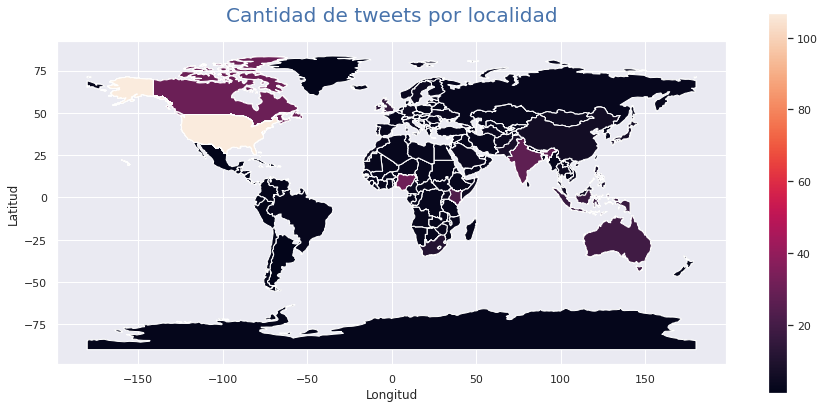

In [359]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Cantidad de tweets por localidad', pad = 20, fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
grafico_final.plot(column='cantidad tw', legend=True, ax=ax)

In [360]:
grafico_promedio_longitudes = grafico_final.groupby('nombre').agg({'longitud':'mean'})
grafico_promedio_longitudes_new = grafico_promedio_longitudes.copy()
grafico_promedio_longitudes_new['name'] = grafico_promedio_longitudes.index
grafico_promedio_longitudes_new.columns = ['promedio longitud', 'name']
grafico_promedio_longitudes_new.head()

,promedio longitud,name
nombre,,
Afghanistan,135.000000,Afghanistan
Albania,93.500000,Albania
Algeria,120.666667,Algeria
Angola,120.666667,Angola
Antarctica,107.000000,Antarctica


In [361]:
grafico_2_final = pd.merge(world_train_final, grafico_promedio_longitudes_new, on='name', how='left')
grafico_2_final.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,id,keyword,text,target,longitud,promedio longitud
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,120.666667
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,120.666667
2,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",10748,wreckage,Malaysia PM confirms wreckage belongs to MH370...,1,92,120.666667
3,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,120.666667
4,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,120.666667


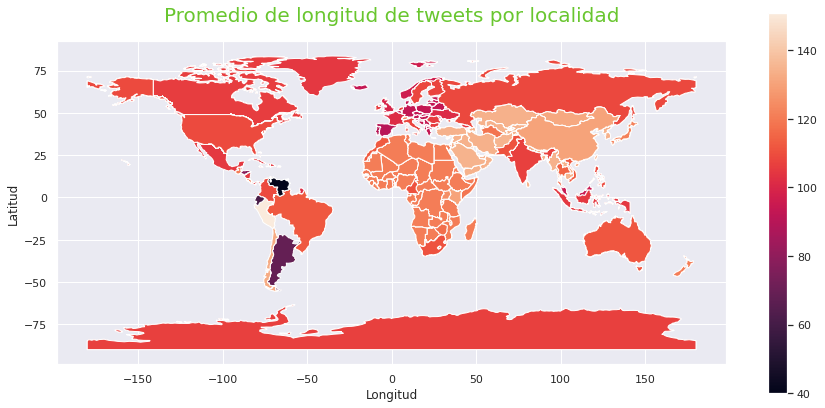

In [362]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Promedio de longitud de tweets por localidad', pad = 20, fontdict={'fontsize':20, 'color': '#69c62f'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
grafico_2_final.plot(column='promedio longitud', legend=True, ax=ax)

In [363]:
grafico_final['target'].sum()

549

In [364]:
def promedio(x):
  return (x.sum()/x.count())*100

mapa_new = grafico_final.groupby('nombre').agg({'target':promedio})
mapa_porcentaje_veracidad = mapa_new.copy()
mapa_porcentaje_veracidad['name'] = mapa_new.index
mapa_porcentaje_veracidad.columns = ['porcentaje veracidad','name']
mapa_porcentaje_veracidad.head(30)

,porcentaje veracidad,name
nombre,,
Afghanistan,75.000000,Afghanistan
Albania,100.000000,Albania
Algeria,100.000000,Algeria
Angola,100.000000,Angola
Antarctica,100.000000,Antarctica
Argentina,0.000000,Argentina
Armenia,66.666667,Armenia
Australia,47.368421,Australia
Austria,100.000000,Austria


In [365]:
grafico_3_final = pd.merge(world_train_final, mapa_porcentaje_veracidad, on='name', how='left')
grafico_3_final.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,id,keyword,text,target,longitud,porcentaje veracidad
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,100.0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,100.0
2,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",10748,wreckage,Malaysia PM confirms wreckage belongs to MH370...,1,92,100.0
3,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,100.0
4,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,100.0


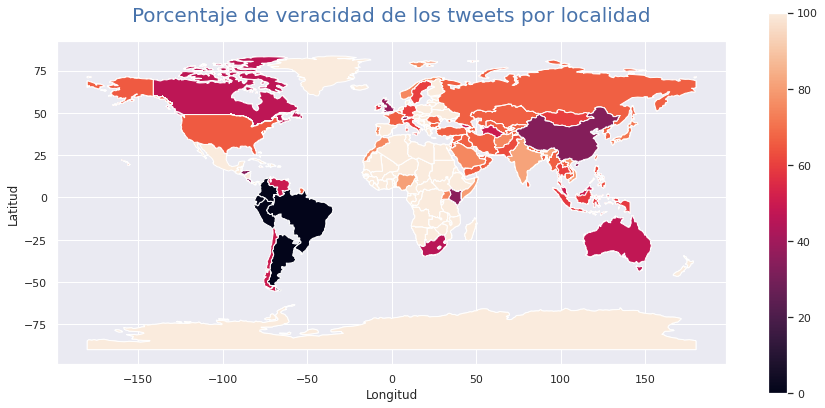

In [366]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Porcentaje de veracidad de los tweets por localidad', pad = 20, fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
grafico_3_final.plot(column='porcentaje veracidad', legend=True, ax=ax)

In [367]:
def promedio(x):
  return (x.sum()/grafico_final['target'].sum())*100

mapa_new_2 = grafico_final.groupby('nombre').agg({'target':promedio})
mapa_porcentaje_veracidad_2 = mapa_new_2.copy()
mapa_porcentaje_veracidad_2['name'] = mapa_new_2.index
mapa_porcentaje_veracidad_2.columns = ['porcentaje veracidad','name']
mapa_porcentaje_veracidad_2.head(30)

,porcentaje veracidad,name
nombre,,
Afghanistan,0.546448,Afghanistan
Albania,0.364299,Albania
Algeria,0.546448,Algeria
Angola,0.546448,Angola
Antarctica,0.364299,Antarctica
Argentina,0.000000,Argentina
Armenia,0.364299,Armenia
Australia,1.639344,Australia
Austria,0.364299,Austria


In [368]:
grafico_4_final = pd.merge(world_train_final, mapa_porcentaje_veracidad_2, on='name', how='left')
grafico_4_final.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,id,keyword,text,target,longitud,porcentaje veracidad
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,0.546448
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,0.546448
2,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",10748,wreckage,Malaysia PM confirms wreckage belongs to MH370...,1,92,0.546448
3,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",4706,epicentre,RT @calestous: Tanzania elephant population de...,1,134,0.546448
4,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",8150,rescuers,@Durban_Knight Rescuers are searching for hund...,1,136,0.546448


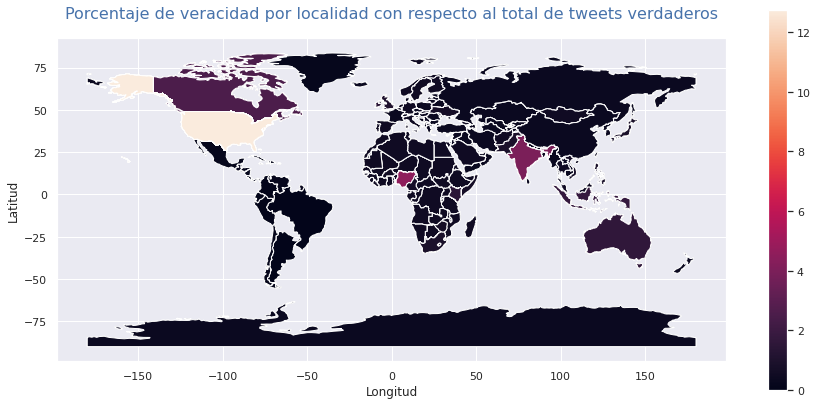

In [369]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Porcentaje de veracidad por localidad con respecto al total de tweets verdaderos', pad = 20, fontdict={'fontsize':16, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
grafico_4_final.plot(column='porcentaje veracidad', legend=True, ax=ax)

In [370]:
tabla = grafico_final[['keyword', 'continent', 'target']].pivot_table(index='keyword',columns='continent',values='target', aggfunc='count')
tabla.index = tabla.index.str.replace('%20', ' ')
tabla

continent,Africa,Antarctica,Asia,Europe,North America,Oceania,South America
keyword,,,,,,,
ablaze,1.0,NaN,1.0,NaN,1.0,NaN,NaN
accident,NaN,NaN,NaN,NaN,NaN,1.0,NaN
aftershock,NaN,NaN,NaN,5.0,NaN,NaN,NaN
airplane accident,NaN,NaN,3.0,NaN,1.0,NaN,NaN
ambulance,NaN,NaN,NaN,NaN,2.0,NaN,NaN
...,...,...,...,...,...,...,...
wildfire,NaN,NaN,NaN,NaN,2.0,1.0,NaN
windstorm,NaN,NaN,NaN,NaN,2.0,NaN,NaN
wounded,NaN,NaN,NaN,NaN,3.0,NaN,1.0


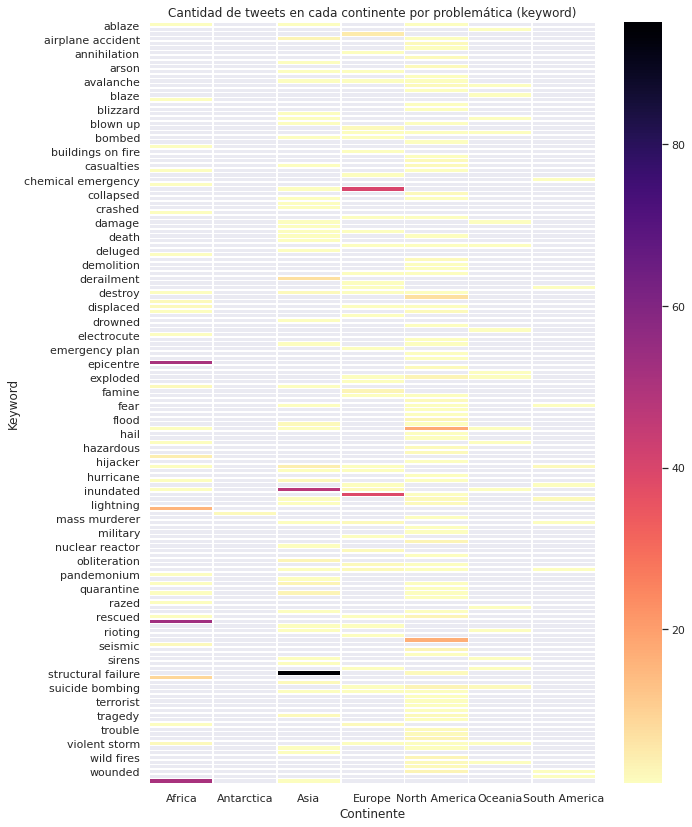

In [371]:
fig, ax = plt.subplots(figsize = (10, 14))
g = sns.heatmap(tabla, cmap='magma_r', linewidths=0.5, ax=ax)
g.set_title('Cantidad de tweets en cada continente por problemática (keyword)');
g.set_ylabel('Keyword');
g.set_xlabel('Continente');
plt.savefig('desastres_naturales_por_continente.png')

In [372]:
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
cities.count()

name        202
geometry    202
dtype: int64

In [373]:
train.columns = ['id', 'keyword', 'name', 'text', 'target', 'longitud']
cities_train = pd.merge(cities, train, how='inner', on='name')
cities_train.head()

,name,geometry,id,keyword,text,target,longitud
0,Islamabad,POINT (73.16469 33.70194),2637,crashed,Army sources say 12 persons on board including...,1,140
1,Pretoria,POINT (28.22748 -25.70497),54,ablaze,@PhDSquares #mufc they've built so much hype a...,0,122
2,Pretoria,POINT (28.22748 -25.70497),3695,destroy,As I catch the last few minutes. Finally Monwa...,0,135
3,Wellington,POINT (174.78327 -41.29997),3229,deluged,@TheSewphist whoever holds the address 'fuckfa...,0,108
4,Abuja,POINT (7.53138 9.08528),78,ablaze,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0,130


In [374]:
cities_train.count()

name        111
geometry    111
id          111
keyword     111
text        111
target      111
longitud    111
dtype: int64

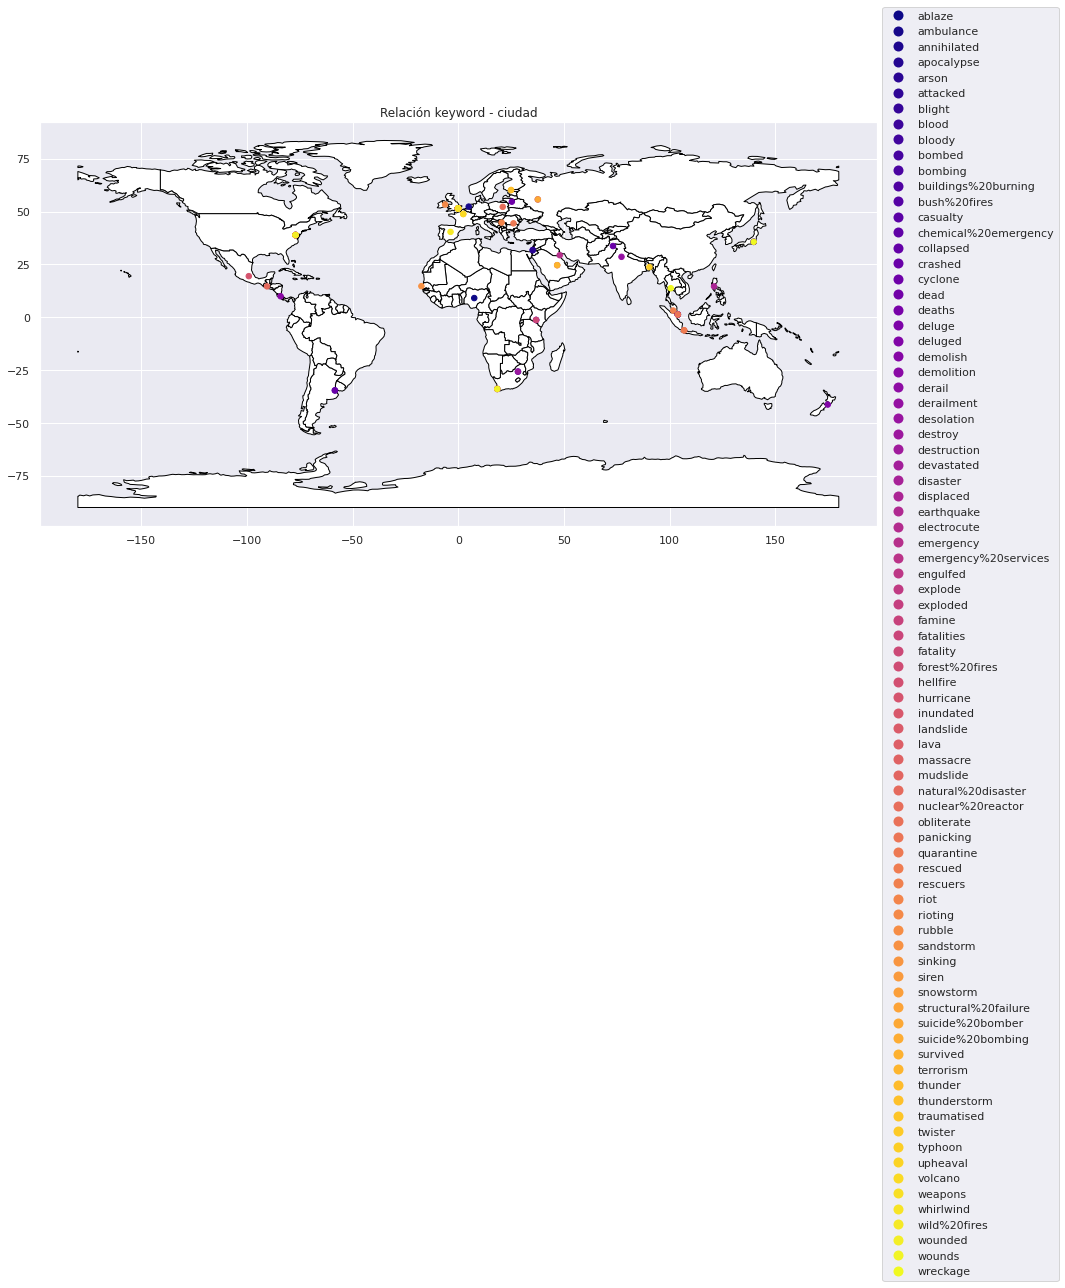

In [375]:
fig, ax = plt.subplots(figsize = (15, 15))
world.plot(ax=ax, color='white', edgecolor='black')
ax.set_title('Relación keyword - ciudad')

viridis = cm.get_cmap('plasma', 256)
newcolors = viridis(np.linspace(0, 1, 256))
cmap = ListedColormap(newcolors)

cities_train.plot(column='keyword', ax=ax, marker='o', markersize=30, legend=True, cmap=cmap)
ax.get_legend().set_bbox_to_anchor((1,1.3))
plt.show()